In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# Load the data
df = pd.read_csv('../data/cleaned_superstore_sales.csv')

# Convert date columns to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Extract date features
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Day'] = df['Order Date'].dt.day
df['DayOfWeek'] = df['Order Date'].dt.dayofweek

# Drop unnecessary columns
columns_to_drop = ['Row ID', 'Order ID', 'Ship Date',
                   'Product ID','Order Date',
                   'Postal Code', 'Customer ID']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Convert categorical variables to numeric using label encoding
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df[col] = pd.Categorical(df[col]).codes

# Verify no string columns remain
print("\nDataframe Info:")
print(df.info())

print("\nData shape after initial preprocessing:", df.shape)


Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ship Mode      9800 non-null   int8   
 1   Customer Name  9800 non-null   int16  
 2   Segment        9800 non-null   int8   
 3   Country        9800 non-null   int8   
 4   City           9800 non-null   int16  
 5   State          9800 non-null   int8   
 6   Region         9800 non-null   int8   
 7   Category       9800 non-null   int8   
 8   Sub-Category   9800 non-null   int8   
 9   Product Name   9800 non-null   int16  
 10  Sales          9800 non-null   float64
 11  Year           9800 non-null   int32  
 12  Month          9800 non-null   int32  
 13  Day            9800 non-null   int32  
 14  DayOfWeek      9800 non-null   int32  
 15  ShippingDays   9800 non-null   int64  
dtypes: float64(1), int16(3), int32(4), int64(1), int8(7)
memory usage: 430.8 KB
Non

In [3]:
df.head()

,Ship Mode,Customer Name,Segment,Country,City,State,Region,Category,Sub-Category,Product Name,Sales,Year,Month,Day,DayOfWeek,ShippingDays
0,3,198,0,0,207,41,0,1,12,1080,16.448,2015,1,3,5,4
1,3,611,2,0,319,11,0,1,3,707,3.540,2015,1,4,6,4
2,3,611,2,0,319,11,0,1,14,1363,272.736,2015,1,4,6,4
3,3,611,2,0,319,11,0,1,10,217,11.784,2015,1,4,6,4
4,3,537,0,0,372,36,1,1,2,250,19.536,2015,1,5,0,7


Original dataset size: 9800
Dataset size after removing outliers: 9558
Number of outliers removed: 242


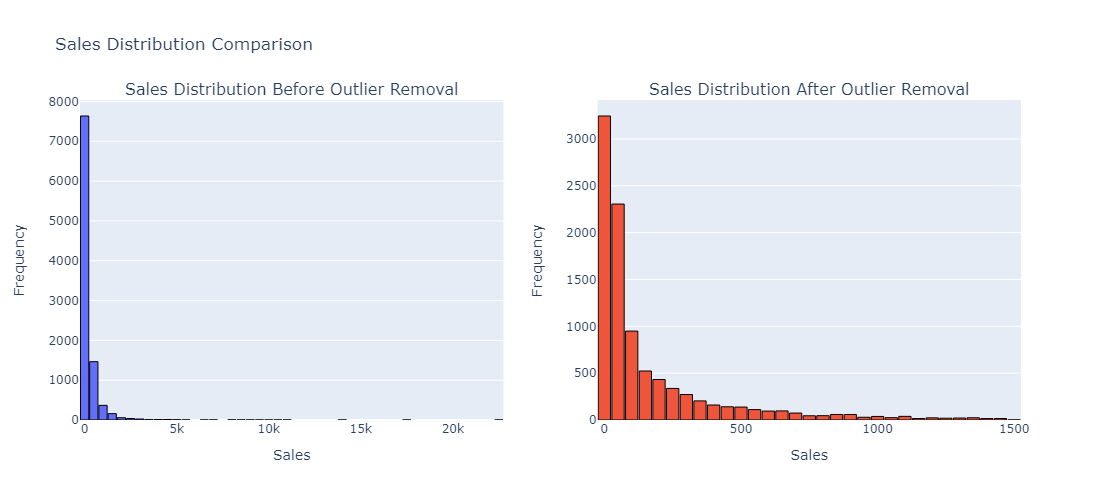

In [4]:
# Remove outliers from Sales using z-score method
z_scores = stats.zscore(df['Sales'])
abs_z_scores = np.abs(z_scores)
filtered_entries = abs_z_scores < 2
df_cleaned = df[filtered_entries]

print(f"Original dataset size: {len(df)}")
print(f"Dataset size after removing outliers: {len(df_cleaned)}")
print(f"Number of outliers removed: {len(df) - len(df_cleaned)}")

# Show sales distribution before and after

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Sales Distribution Before Outlier Removal',
                   'Sales Distribution After Outlier Removal')
)

# Add histograms
fig.add_trace(
    go.Histogram(x=df['Sales'], 
                nbinsx=50,
                marker_line_width=1,
                marker_line_color='black'),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=df_cleaned['Sales'],
                nbinsx=50,
                marker_line_width=1,
                marker_line_color='black'),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title_text='Sales Distribution Comparison',
    showlegend=False,
    height=500,
    width=1200,
    bargap=0.1,
)

# Update x and y axis labels
fig.update_xaxes(title_text='Sales', row=1, col=1)
fig.update_xaxes(title_text='Sales', row=1, col=2)
fig.update_yaxes(title_text='Frequency', row=1, col=1)
fig.update_yaxes(title_text='Frequency', row=1, col=2)

# Display the plot
fig.show()

In [5]:
# Separate features and target
X = df.drop('Sales', axis=1)
y = df['Sales']

# Verify all features are numeric
print("Feature datatypes:")
print(X.dtypes)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

print("\nTraining set shape:", X_train_scaled.shape)
print("Validation set shape:", X_valid_scaled.shape)
print("Test set shape:", X_test_scaled.shape)

Feature datatypes:
Ship Mode         int8
Customer Name    int16
Segment           int8
Country           int8
City             int16
State             int8
Region            int8
Category          int8
Sub-Category      int8
Product Name     int16
Year             int32
Month            int32
Day              int32
DayOfWeek        int32
ShippingDays     int64
dtype: object

Training set shape: (6272, 15)
Validation set shape: (1568, 15)
Test set shape: (1960, 15)


In [6]:
# Create and configure the XGBoost model with better parameters
model = XGBRegressor(
    n_estimators=1000,          # Increase number of trees
    learning_rate=0.01,         # Reduce learning rate
    max_depth=4,                # Reduce max_depth to prevent overfitting
    min_child_weight=5,         # Add min_child_weight to reduce overfitting
    subsample=0.8,              # Use only 80% of data per tree
    colsample_bytree=0.8,       # Use only 80% of features per tree
    reg_alpha=0.1,              # L1 regularization
    reg_lambda=1.0,             # L2 regularization
    random_state=42
)

# Train the model with early stopping
model.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_valid_scaled, y_valid)],
    eval_metric='rmse',
    early_stopping_rounds=50,    # Stop if no improvement for 50 rounds
    verbose=True
)

[0]	validation_0-rmse:625.73949	validation_1-rmse:606.32155
[1]	validation_0-rmse:624.92223	validation_1-rmse:605.87424
[2]	validation_0-rmse:623.61047	validation_1-rmse:605.01394
[3]	validation_0-rmse:621.91218	validation_1-rmse:604.14048
[4]	validation_0-rmse:620.69818	validation_1-rmse:603.43461
[5]	validation_0-rmse:619.90365	validation_1-rmse:603.01323
[6]	validation_0-rmse:618.05381	validation_1-rmse:602.30107
[7]	validation_0-rmse:616.45720	validation_1-rmse:601.26159
[8]	validation_0-rmse:615.10857	validation_1-rmse:600.31493
[9]	validation_0-rmse:613.75941	validation_1-rmse:599.50128
[10]	validation_0-rmse:612.57254	validation_1-rmse:598.73634
[11]	validation_0-rmse:611.46274	validation_1-rmse:598.37918
[12]	validation_0-rmse:610.18854	validation_1-rmse:597.97894
[13]	validation_0-rmse:609.39547	validation_1-rmse:597.58074
[14]	validation_0-rmse:608.01721	validation_1-rmse:597.17773
[15]	validation_0-rmse:607.62605	validation_1-rmse:596.84452
[16]	validation_0-rmse:606.59568	v

C:\Users\nouha\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\nouha\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[106]	validation_0-rmse:536.25637	validation_1-rmse:581.76287
[107]	validation_0-rmse:536.12963	validation_1-rmse:581.65395
[108]	validation_0-rmse:535.84073	validation_1-rmse:581.58914
[109]	validation_0-rmse:535.22798	validation_1-rmse:581.58890
[110]	validation_0-rmse:534.57955	validation_1-rmse:582.01875
[111]	validation_0-rmse:534.02732	validation_1-rmse:581.82073
[112]	validation_0-rmse:533.76226	validation_1-rmse:581.64272
[113]	validation_0-rmse:533.16651	validation_1-rmse:581.92715
[114]	validation_0-rmse:533.02120	validation_1-rmse:581.88013
[115]	validation_0-rmse:532.90243	validation_1-rmse:581.84897
[116]	validation_0-rmse:532.69342	validation_1-rmse:581.75017
[117]	validation_0-rmse:532.15619	validation_1-rmse:581.67173
[118]	validation_0-rmse:531.62171	validation_1-rmse:581.73013
[119]	validation_0-rmse:531.03609	validation_1-rmse:581.87106
[120]	validation_0-rmse:530.43806	validation_1-rmse:581.75406
[121]	validation_0-rmse:530.31183	validation_1-rmse:581.72725
[122]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [7]:
# Make predictions on test set
y_pred = model.predict(X_test_scaled)

# Calculate RMSE on test set
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print(f"\nTest Set RMSE: {rmse:.2f}")

# Calculate R-squared score
r2 = 1 - np.sum((y_test - y_pred) ** 2) / np.sum((y_test - y_test.mean()) ** 2)
print(f"R-squared Score: {r2:.4f}")

# Calculate feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
})
print("\nTop 10 Most Important Features:")
print(feature_importance.sort_values('importance', ascending=False).head(10))


Test Set RMSE: 563.65
R-squared Score: 0.2210

Top 10 Most Important Features:
          feature  importance
1   Customer Name    0.243096
10           Year    0.153064
8    Sub-Category    0.151099
7        Category    0.122369
9    Product Name    0.083640
13      DayOfWeek    0.043545
4            City    0.040429
14   ShippingDays    0.036903
11          Month    0.028915
6          Region    0.028340


In [8]:
# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

fig = px.bar(
    feature_importance.head(15), 
    x='importance', 
    y='feature',
    title='Top 15 Most Important Features',
    orientation='h'
)
fig.show()

In [9]:
# Plot actual vs predicted values
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

fig = px.scatter(
    comparison_df,
    x='Actual',
    y='Predicted',
    title='Actual vs Predicted Sales',
    labels={'Actual': 'Actual Sales ($)', 'Predicted': 'Predicted Sales ($)'}
)

# Add perfect prediction line
fig.add_scatter(
    x=[comparison_df.Actual.min(), comparison_df.Actual.max()],
    y=[comparison_df.Actual.min(), comparison_df.Actual.max()],
    mode='lines',
    name='Perfect Prediction',
    line=dict(dash='dash')
)

fig.show()